# 📊 Superstore Data Quality and Profit/Loss Analysis Summary

This notebook performs a **comprehensive data quality check** and an **in-depth analysis of Superstore sales performance**, focusing on identifying data integrity issues and prioritizing areas of significant financial loss.

---

## 📝 Key Data Quality Findings

**Data Integrity is High**  
The initial dataset of 9,994 records showed no missing values (NaNs) in any column, and only 2 exact duplicate rows were found and removed, resulting in a clean final dataset of **9,993 unique rows**.

**Geospatial Inconsistencies Detected**  
An advanced validation check using the `pgeocode` library identified **1,668 rows** with potential geographical mismatches (City/State/Postal Code).  
After a looser check to account for naming variations, **748 records** remained flagged.  

Primary issues include:  
- **449 records** where the Postal Code could not be externally validated  
- **299 records** where the listed City name did not match the expected city for that ZIP code (a *City Issue*)  

**Product ID Conflicts Resolved**  
32 unique Product IDs were incorrectly mapped to multiple different Product Names (e.g., one ID representing two different bookcases).  
This was resolved by creating a **`Clean_Product_ID`** by concatenating the original ID and Name, ensuring accurate profit tracking.

**Customer ID Inconsistencies**  
Several Customer IDs were linked to multiple conflicting attributes (e.g., different Customer Name or City).  
This suggests potential issues in customer data entry or system integrity, requiring further review.

---

## 💸 Key Profit/Loss Findings (Actionable Insights)

**Discount is Not Driving Losses**  
Spearman correlation analysis on negative profit orders reveals:  
- Strong negative correlation between **Sales and Profit**: -0.75  
- Near-zero correlation between **Discount and Profit**: 0.041  

This indicates that discount percentage is **not the main driver of losses** in these scenarios, highlighting the need for further investigation.

**The Pareto Principle Applies to Loss**  
Cumulative analysis of total negative profit showed that **36 unique products contribute to over 50%** of the total financial loss.  
These products represent **high-impact targets** for profit optimization.

**Highest Loss Severity**  
The product with the most severe loss ratio (**Total Loss / Total Sales**) is:  
- **Eureka Disposable Bags (OFF-AP-10002203)**  
- Ratio: -2.75 (meaning for every $1 in sales, the company lost $2.75 in profit)

---

This notebook provides the foundation for some follow-up projects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode

In [2]:
file_path = r"C:\Users\tajes\Downloads\Sample - Superstore.csv"
df = pd.read_csv(file_path, encoding='latin1', index_col=0)

In [3]:
print(df.shape)
print("-"*50)
print(df.dtypes)
print("-"*50)

(9994, 20)
--------------------------------------------------
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object
--------------------------------------------------


In [4]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y', errors='coerce')

In [6]:
categorical_cols = [
    'Ship Mode', 'Segment', 'Country', 'City', 'State', 
    'Region', 'Category', 'Sub-Category'
]

for col in categorical_cols:
    df[col] = df[col].str.strip() if df[col].dtype == 'object' else df[col]
    
    unique_vals = df[col].unique()
    num_unique = df[col].nunique()
    
    # Check for lowercase/typo issues
    lower_case = [v for v in unique_vals if isinstance(v, str) and v[0].islower()]
    extra_spaces = [v for v in unique_vals if isinstance(v, str) and ('  ' in v or v.startswith(' ') or v.endswith(' '))]
    
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {num_unique}")
    print(f"Unique values: {unique_vals}")
    
    if lower_case:
        print(f"Values starting with lowercase: {lower_case}")
    if extra_spaces:
        print(f"Values with extra spaces: {extra_spaces}")



Column: Ship Mode
Number of unique values: 4
Unique values: ['Second Class' 'Standard Class' 'First Class' 'Same Day']

Column: Segment
Number of unique values: 3
Unique values: ['Consumer' 'Corporate' 'Home Office']

Column: Country
Number of unique values: 1
Unique values: ['United States']

Column: City
Number of unique values: 531
Unique values: ['Henderson' 'Los Angeles' 'Fort Lauderdale' 'Concord' 'Seattle'
 'Fort Worth' 'Madison' 'West Jordan' 'San Francisco' 'Fremont'
 'Philadelphia' 'Orem' 'Houston' 'Richardson' 'Naperville' 'Melbourne'
 'Eagan' 'Westland' 'Dover' 'New Albany' 'New York City' 'Troy' 'Chicago'
 'Gilbert' 'Springfield' 'Jackson' 'Memphis' 'Decatur' 'Durham' 'Columbia'
 'Rochester' 'Minneapolis' 'Portland' 'Saint Paul' 'Aurora' 'Charlotte'
 'Orland Park' 'Urbandale' 'Columbus' 'Bristol' 'Wilmington' 'Bloomington'
 'Phoenix' 'Roseville' 'Independence' 'Pasadena' 'Newark' 'Franklin'
 'Scottsdale' 'San Jose' 'Edmond' 'Carlsbad' 'San Antonio' 'Monroe'
 'Fairfield' '

In [7]:
def check_text_column(col_name):
    df[col_name] = df[col_name].str.strip()
    extra_spaces = df[df[col_name].str.contains(r'\s{2,}', regex=True)]
    not_capitalized = df[df[col_name].str.match(r'^[a-z]', na=False)]
    print(f"\nColumn: {col_name}")
    print(f"Total rows: {len(df)}")
    print(f"Rows with extra spaces:\n{extra_spaces[[col_name]]}")
    print(f"Rows not starting with capital letter:\n{not_capitalized[[col_name]]}")
    print(f"Unique values: {df[col_name].nunique()}\n")

check_text_column('Customer Name')
check_text_column('City')


Column: Customer Name
Total rows: 9994
Rows with extra spaces:
Empty DataFrame
Columns: [Customer Name]
Index: []
Rows not starting with capital letter:
Empty DataFrame
Columns: [Customer Name]
Index: []
Unique values: 793


Column: City
Total rows: 9994
Rows with extra spaces:
Empty DataFrame
Columns: [City]
Index: []
Rows not starting with capital letter:
Empty DataFrame
Columns: [City]
Index: []
Unique values: 531



In [8]:
df.isnull().sum()

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [9]:
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Total duplicate rows: {len(duplicate_rows)}")
if len(duplicate_rows) > 0:
    print("Sample duplicates:")
    print(duplicate_rows.head())
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Total duplicate rows: 2
Sample duplicates:
              Order ID Order Date  Ship Date       Ship Mode Customer ID  \
Row ID                                                                     
3406    US-2014-150119 2014-04-23 2014-04-27  Standard Class    LB-16795   
3407    US-2014-150119 2014-04-23 2014-04-27  Standard Class    LB-16795   

         Customer Name      Segment        Country      City State  \
Row ID                                                               
3406    Laurel Beltran  Home Office  United States  Columbus  Ohio   
3407    Laurel Beltran  Home Office  United States  Columbus  Ohio   

        Postal Code Region       Product ID   Category Sub-Category  \
Row ID                                                                
3406          43229   East  FUR-CH-10002965  Furniture       Chairs   
3407          43229   East  FUR-CH-10002965  Furniture       Chairs   

                                             Product Name    Sales  Quantity  \
Row ID

In [10]:
df['Postal Code'] = df['Postal Code'].astype(str)
nomi = pgeocode.Nominatim("US")

def is_location_valid(row):
    postal_code = str(row['Postal Code'])
    city = str(row['City']).lower()
    state = str(row['State']).lower() if pd.notna(row['State']) else ""
    info = nomi.query_postal_code(postal_code)
    if info is None or pd.isna(info.place_name) or pd.isna(info.state_name):
        return False
    return city in str(info.place_name).lower() and state in str(info.state_name).lower()

df['Location_Valid'] = df.apply(is_location_valid, axis=1)
print(df[['City', 'State', 'Postal Code', 'Location_Valid']].head())

                   City       State Postal Code  Location_Valid
Row ID                                                         
1             Henderson    Kentucky       42420            True
2             Henderson    Kentucky       42420            True
3           Los Angeles  California       90036            True
4       Fort Lauderdale     Florida       33311            True
5       Fort Lauderdale     Florida       33311            True


In [11]:
print(df['Location_Valid'].value_counts())
invalid_locations = df[df['Location_Valid'] == False]
print(invalid_locations[['City', 'State', 'Postal Code', 'Region']])

Location_Valid
True     8325
False    1668
Name: count, dtype: int64
                 City       State Postal Code   Region
Row ID                                                
45              Eagan   Minnesota       55122  Central
46              Eagan   Minnesota       55122  Central
54      New York City    New York       10024     East
55      New York City    New York       10024     East
71      New York City    New York       10009     East
...               ...         ...         ...      ...
9940    New York City    New York       10009     East
9941    New York City    New York       10009     East
9968       Plainfield  New Jersey        7060     East
9969       Plainfield  New Jersey        7060     East
9970       Plainfield  New Jersey        7060     East

[1668 rows x 4 columns]


In [12]:
invalid_locations = df[df['Location_Valid'] == False]

print("--- Top 5 States with Invalid Locations ---")
print(invalid_locations['State'].value_counts().head(5))

print("\n--- Count of Zip Codes that are '0' ---")
print(invalid_locations[invalid_locations['Postal Code'] == '0'].shape[0])

--- Top 5 States with Invalid Locations ---
State
New York         915
Massachusetts    135
New Jersey       130
California        96
Connecticut       82
Name: count, dtype: int64

--- Count of Zip Codes that are '0' ---
0


In [13]:
def is_location_valid_loose(row):
    postal_code = str(row['Postal Code'])
    city = str(row['City']).lower()
    state = str(row['State']).lower() if pd.notna(row['State']) else ""
    info = nomi.query_postal_code(postal_code)
    if info is None or pd.isna(info.place_name) or pd.isna(info.state_name):
        return False
    result_city = str(info.place_name).lower()
    result_state = str(info.state_name).lower()
    city_match = city in result_city or result_city in city
    state_match = state == result_state
    return city_match and state_match

df['Location_Valid_Loose'] = df.apply(
    lambda row: is_location_valid_loose(row) if not row['Location_Valid'] else True, axis=1
)

print(df['Location_Valid_Loose'].value_counts())
invalid_locations_loose = df[df['Location_Valid_Loose'] == False]
print(f"Remaining invalid locations: {len(invalid_locations_loose)} rows")



Location_Valid_Loose
True     9245
False     748
Name: count, dtype: int64
Remaining invalid locations: 748 rows


In [14]:
invalid_subset = invalid_locations_loose.copy()

def identify_location_issue(row):
    postal_code = str(row['Postal Code'])
    city = str(row['City']).lower()
    state = str(row['State']).lower() if pd.notna(row['State']) else ""
    
    info = nomi.query_postal_code(postal_code)
    if info is None or pd.isna(info.place_name) or pd.isna(info.state_name):
        return "Postal Code Not Found"
    
    result_city = str(info.place_name).lower()
    result_state = str(info.state_name).lower()
    
    city_match = city in result_city or result_city in city
    state_match = state == result_state
    
    if city_match and state_match:
        return "All Match"
    elif state_match:
        return "City Issue"
    elif city_match:
        return "State Issue"
    else:
        return "Both City and State Issue"

invalid_subset['Location_Issue'] = invalid_subset.apply(identify_location_issue, axis=1)

issue_counts = invalid_subset['Location_Issue'].value_counts()
print(issue_counts)

for issue in issue_counts.index:
    print(f"\nSample rows with issue: {issue}")
    print(invalid_subset[invalid_subset['Location_Issue'] == issue][['City','State','Postal Code','Region']].head())


Location_Issue
Postal Code Not Found    449
City Issue               299
Name: count, dtype: int64

Sample rows with issue: Postal Code Not Found
              City        State Postal Code Region
Row ID                                            
186      Fairfield  Connecticut        6824   East
198      Westfield   New Jersey        7090   East
268     Morristown   New Jersey        7960   East
299     Belleville   New Jersey        7109   East
300     Belleville   New Jersey        7109   East

Sample rows with issue: City Issue
             City       State Postal Code   Region
Row ID                                            
45          Eagan   Minnesota       55122  Central
46          Eagan   Minnesota       55122  Central
251     San Diego  California       92037     West
252     San Diego  California       92037     West
287       Tamarac     Florida       33319    South


In [15]:
id_unique = df['Product ID'].nunique()
name_unique = df['Product Name'].nunique()
conflicts = df.groupby('Product ID')['Product Name'].nunique()
conflicting_ids = conflicts[conflicts > 1]
print(f"Product IDs: {id_unique}, Product Names: {name_unique}")
print(f"Conflicting Product IDs: {len(conflicting_ids)}")

Product IDs: 1862, Product Names: 1850
Conflicting Product IDs: 32


In [16]:
# Identify conflicting Product IDs
conflicts = df.groupby('Product ID')['Product Name'].nunique()
conflicting_ids = conflicts[conflicts > 1].index

# Inspect the actual conflicting rows
conflict_details = df[df['Product ID'].isin(conflicting_ids)][
    ['Product ID', 'Product Name', 'Category', 'Sub-Category']
].sort_values('Product ID')

print(conflict_details)


             Product ID                                      Product Name  \
Row ID                                                                      
5080    FUR-BO-10002213  Sauder Forest Hills Library, Woodland Oak Finish   
2472    FUR-BO-10002213  Sauder Forest Hills Library, Woodland Oak Finish   
9650    FUR-BO-10002213             DMI Eclipse Executive Suite Bookcases   
9584    FUR-BO-10002213             DMI Eclipse Executive Suite Bookcases   
9396    FUR-BO-10002213             DMI Eclipse Executive Suite Bookcases   
...                 ...                                               ...   
923     TEC-PH-10004531     OtterBox Commuter Series Case - iPhone 5 & 5s   
8997    TEC-PH-10004531     OtterBox Commuter Series Case - iPhone 5 & 5s   
3066    TEC-PH-10004531     OtterBox Commuter Series Case - iPhone 5 & 5s   
2714    TEC-PH-10004531                                       AT&T CL2909   
8971    TEC-PH-10004531                                       AT&T CL2909   

In [17]:
conflict_names_counts = df[df['Product ID'].isin(conflicting_ids)][
    ['Product ID', 'Product Name']
].groupby(['Product ID', 'Product Name']).size().reset_index(name='count')

conflict_names_counts = conflict_names_counts.sort_values(['Product ID', 'count'], ascending=[True, False])
print(conflict_names_counts)


         Product ID                                       Product Name  count
0   FUR-BO-10002213              DMI Eclipse Executive Suite Bookcases      6
1   FUR-BO-10002213   Sauder Forest Hills Library, Woodland Oak Finish      4
3   FUR-CH-10001146        Global Value Mid-Back Manager's Chair, Gray     10
2   FUR-CH-10001146                           Global Task Chair, Black      5
4   FUR-FU-10001473                            DAX Wood Document Frame      9
..              ...                                                ...    ...
59  TEC-PH-10002200                              Samsung Galaxy Note 2      2
61  TEC-PH-10002310  Plantronics Calisto P620-M USB Wireless Speake...      4
60  TEC-PH-10002310                 Panasonic KX T7731-B Digital phone      3
63  TEC-PH-10004531      OtterBox Commuter Series Case - iPhone 5 & 5s      4
62  TEC-PH-10004531                                        AT&T CL2909      3

[64 rows x 3 columns]


In [18]:
df['Clean_Product_ID'] = df['Product ID']  # default
df.loc[df['Product ID'].isin(conflicting_ids), 'Clean_Product_ID'] = (
    df['Product ID'] + "__" + df['Product Name']
)


In [19]:
customer_cols = ['Customer Name', 'Segment', 'Country', 'City', 'State']
conflict_counts = df.groupby('Customer ID')[customer_cols].nunique()
conflicting_customers = conflict_counts[(conflict_counts > 1).any(axis=1)].index
conflict_table = df[df['Customer ID'].isin(conflicting_customers)][
    ['Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code']
].sort_values('Customer ID')
print("\nConflicting Customers:")
print(conflict_table)


Conflicting Customers:
       Customer ID       Customer Name   Segment        Country  \
Row ID                                                            
1160      AA-10315          Alex Avila  Consumer  United States   
5199      AA-10315          Alex Avila  Consumer  United States   
7470      AA-10315          Alex Avila  Consumer  United States   
5200      AA-10315          Alex Avila  Consumer  United States   
7469      AA-10315          Alex Avila  Consumer  United States   
...            ...                 ...       ...            ...   
20        ZD-21925  Zuschuss Donatelli  Consumer  United States   
19        ZD-21925  Zuschuss Donatelli  Consumer  United States   
5899      ZD-21925  Zuschuss Donatelli  Consumer  United States   
3816      ZD-21925  Zuschuss Donatelli  Consumer  United States   
5898      ZD-21925  Zuschuss Donatelli  Consumer  United States   

                 City       State Postal Code  
Row ID                                         
1160    

In [20]:
num_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
print("\nNumeric Columns Stats:")
print(df[num_cols].describe())

print("\nTop 10 Most Negative Profit Orders:")
print(df.nsmallest(10, 'Profit')[['Product ID', 'Product Name', 'Sales', 'Discount', 'Profit']])


Numeric Columns Stats:
              Sales     Quantity     Discount       Profit
count   9993.000000  9993.000000  9993.000000  9993.000000
mean     229.852846     3.789753     0.156188    28.660971
std      623.276074     2.225149     0.206457   234.271476
min        0.444000     1.000000     0.000000 -6599.978000
25%       17.280000     2.000000     0.000000     1.731000
50%       54.480000     3.000000     0.200000     8.671000
75%      209.940000     5.000000     0.200000    29.364000
max    22638.480000    14.000000     0.800000  8399.976000

Top 10 Most Negative Profit Orders:
             Product ID                                       Product Name  \
Row ID                                                                       
7773    TEC-MA-10000418          Cubify CubeX 3D Printer Double Head Print   
684     TEC-MA-10004125          Cubify CubeX 3D Printer Triple Head Print   
9775    OFF-BI-10004995          GBC DocuBind P400 Electric Binding System   
3012    TEC-MA-100

In [21]:
all_corr = df[num_cols].corr(method='spearman')
neg_corr = df[df['Profit'] < 0][num_cols].corr(method='spearman')
print("\nSpearman Correlation - All Orders:")
print(all_corr)
print("\nSpearman Correlation - Negative Profit Orders:")
print(neg_corr)


Spearman Correlation - All Orders:
             Sales  Quantity  Discount    Profit
Sales     1.000000  0.327566 -0.057127  0.518682
Quantity  0.327566  1.000000 -0.000737  0.234409
Discount -0.057127 -0.000737  1.000000 -0.543221
Profit    0.518682  0.234409 -0.543221  1.000000

Spearman Correlation - Negative Profit Orders:
             Sales  Quantity  Discount    Profit
Sales     1.000000  0.259423 -0.560217 -0.751042
Quantity  0.259423  1.000000  0.068501 -0.330662
Discount -0.560217  0.068501  1.000000  0.041064
Profit   -0.751042 -0.330662  0.041064  1.000000


In [22]:
loss_analysis = df.groupby(['Clean_Product_ID', 'Product Name']).agg(
    total_loss=('Profit', lambda x: x[x < 0].sum()),
    total_sales=('Sales', 'sum'),
    order_count=('Order ID', 'count'),
    avg_discount=('Discount', 'mean'),
    avg_quantity=('Quantity', 'mean')
).reset_index()

In [23]:
loss_analysis['loss_severity_ratio'] = loss_analysis['total_loss'] / loss_analysis['total_sales']
loss_analysis_sorted = loss_analysis.sort_values('loss_severity_ratio')
print("\nTop 10 Products by Loss Severity:")
print(loss_analysis_sorted.head(10))


Top 10 Products by Loss Severity:
     Clean_Product_ID                                       Product Name  \
427   OFF-AP-10002203  Eureka Disposable Bags for Sanitaire Vibra Gro...   
8     FUR-BO-10001567  Bush Westfield Collection Bookcases, Dark Cher...   
394   OFF-AP-10000390                   Euro Pro Shark Stick Mini Vacuum   
1685  TEC-MA-10003337                               Okidata B401 Printer   
1662  TEC-MA-10001695  Zebra GK420t Direct Thermal/Thermal Transfer P...   
775   OFF-BI-10003166                     GBC Plasticlear Binding Covers   
1652  TEC-MA-10000904  Brother MFC-9340CDW LED All-In-One Printer, Co...   
1668  TEC-MA-10002210  Epson TM-T88V Direct Thermal Printer - Monochr...   
1701  TEC-MA-10004521                Epson Perfection V600 Photo Scanner   
1645  TEC-MA-10000418          Cubify CubeX 3D Printer Double Head Print   

      total_loss  total_sales  order_count  avg_discount  avg_quantity  \
427      -4.4660        1.624            1      0.8000

In [24]:
loss_per_product = loss_analysis_sorted[['Clean_Product_ID', 'total_loss']].sort_values('total_loss')
loss_per_product = loss_per_product[loss_per_product['total_loss'] < 0]
loss_per_product['cum_loss'] = loss_per_product['total_loss'].cumsum()
total_neg_loss = loss_per_product['total_loss'].sum()
loss_per_product['cum_loss_pct'] = loss_per_product['cum_loss'] / total_neg_loss
num_to_50pct = (loss_per_product['cum_loss_pct'] <= 0.5).sum() + 1
top_50pct_products = loss_per_product.head(num_to_50pct)
print(f"\nNumber of products contributing to 50% of negative profit: {num_to_50pct}")
print(top_50pct_products)


Number of products contributing to 50% of negative profit: 36
                                       Clean_Product_ID  total_loss  \
1645                                    TEC-MA-10000418  -9239.9692   
858                                     OFF-BI-10004995  -6859.3896   
1650                                    TEC-MA-10000822  -5269.9690   
667                                     OFF-BI-10000545  -5098.5660   
701                                     OFF-BI-10001359  -4162.0336   
1696                                    TEC-MA-10004125  -3839.9904   
787                                     OFF-BI-10003527  -3431.6730   
326                                     FUR-TA-10000198  -3107.5272   
692                                     OFF-BI-10001120  -2929.4845   
344                                     FUR-TA-10001889  -2545.2600   
49                                      FUR-BO-10004834  -1982.2050   
843   OFF-BI-10004632__Ibico Hi-Tech Manual Binding ...  -1829.9400   
1669          

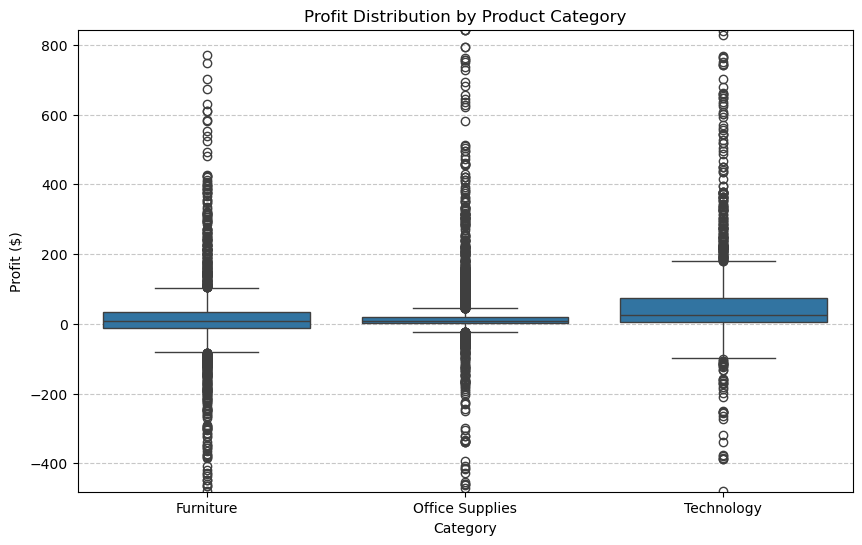

In [25]:
def plot_profit_by_category(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Category', y='Profit', data=data)
    plt.title('Profit Distribution by Product Category')
    plt.xlabel('Category')
    plt.ylabel('Profit ($)')
    lower_limit = data['Profit'].quantile(0.005)
    upper_limit = data['Profit'].quantile(0.995)
    plt.ylim(lower_limit, upper_limit)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('profit_by_category_boxplot.png')

plot_profit_by_category(df)

In [26]:
# Exportloss_analysis_sorted.to_csv("top_loss_products.csv", index=False)
print("Saved: top_loss_products.csv")


Saved: top_loss_products.csv


In [27]:
top_50pct_products.to_csv("top_50pct_loss_products.csv", index=False)
print("Saved: top_50pct_loss_products.csv")

Saved: top_50pct_loss_products.csv


In [28]:
conflict_table.to_csv("conflicting_customers.csv", index=False)
print("Saved: conflicting_customers.csv")

Saved: conflicting_customers.csv


In [29]:
invalid_subset.to_csv("invalid_locations_review.csv", index=False)